In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.autograd import Variable
from typing import Dict, Any, Tuple, Union, NamedTuple
import hydra

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.manual_seed(995)

ntk_steps = 10000

In [2]:

lc = 1e-9
cc = 1e-5
# Physical constants
F = 96485 # Faraday constant [C/mol]
R = 8.3145 # Gas constant [J/(mol·K)]
T = 293 # Temperature [K]
k_B = 1.3806e-23 # Boltzmann constant [J/K]
eps0 = 8.85e-12 # Vacuum permittivity [F/m]
E_min = -1.0  # External applied potential [V] 
E_max = 1.8
# Diffusion coefficients [m²/s]
D_cv = 1.0e-21
D_av = 1.0e-21
D_h = 3.2823e-4

# Mobility coefficients [m²/(V·s)]
U_cv = -1.0562e-19
U_av = 7.9212e-20
U_h = 0.013 # mo_h from COMSOL

# Species charges
z_cv = -2.6667 # -8/3
z_av = 2
z_h = 1

# Permittivities [F/m]
epsilonf = 1.239e-10 # 14*eps0
eps_film = 1.239e-10 # Same as epsilonf
eps_Ddl = 1.77e-11 # 2*eps0
eps_dl = 6.947e-10 # 78.5*eps0
eps_sol = 6.947e-10 # Same as eps_dl

# Semiconductor properties
c_h0 = 4.1683e-4 # Intrinsic hole concentration [mol/m³]
c_e0 = 9.5329e-28 # Intrinsic electron concentration [mol/m³]
tau = 4.9817e-13 # Recombination time constant [s·mol/m³]
Nc = 166.06 # Conduction band density [mol/m³]
Nv = 1.6606e5 # Valence band density [mol/m³]
mu_e0 = 2.4033e-19 # Standard electron chemical potential [J]
Ec0 = 5.127e-19 # Conduction band edge [J]
Ev0 = 1.6022e-19 # Valence band edge [J]

# Solution properties
c_H = 0.01 # Proton concentration [mol/m³]
pH = 5

# Molar volume
Omega = 1.4e-5 # [m³/mol]
# Standard rate constants
k1_0 = 4.5e-8 # [m/s]
k2_0 = 3.6e-6 # [mol/(m²·s)]
k3_0 = 4.5e-9 # [mol/(m²·s)]
k4_0 = 2.25e-7 # [m/s]
k5_0 = 7.65e-9 # [mol/(m²·s)]
ktp_0 = 4.5e-8 # [-]
ko2_0 = 0.005 # [m/s]

# Charge transfer coefficients
alpha_cv = 0.3
alpha_av = 0.8
beta_cv = 0.1
beta_av = 0.8
alpha_tp = 0.2
a_par = 0.45 # For oxygen evolution
delta3 = 1.0

# Derived parameters [1/V]
a_cv = 23.764 # alpha_cv * 2 * F/(R*T)
a_av = 84.493 # alpha_av * 8/3 * F/(R*T)
b_cv = 7.9212 # beta_cv * 2 * F/(R*T)

# Geometric parameters [m]
d_Ddl = 2.0e-10 # Defect layer thickness
d_dl = 5.0e-10 # Double layer thickness
L_cell = 1.0e-6 # Cell length

# Equilibrium potentials
phi_O2_eq = 1.35 # [V]
phic = (R*T)/F
tc = (lc ** 2) / D_cv
L_initial = 1e-9
time_scale =  36000 # Time scale for the simulation [s]

In [3]:
#Define networks

class Swish(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self,x):
        return torch.sigmoid(x)*x
    

class FFN(nn.Module):
    """
    Fully Connected Feed Forward Neural Network.
    Args:
        input_dim: Number of input features
        output_dim: Number of output features  
        hidden_layers: Number of hidden layers
        layer_size: Size of each hidden layer
        activation: Activation function name ('swish', 'swoosh', 'swash', 'squash_swish', 'relu', 'tanh')
        initialize_weights: Whether to apply Xavier initialization
    """
    def __init__(
        self,
        input_dim: int = 3,
        output_dim: int = 1,
        hidden_layers: int = 5,
        layer_size: int = 20,
        activation: str = "swish",
        initialize_weights: bool = False
    ):
        super(FFN, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = hidden_layers
        self.layer_size = layer_size
        self.activation = Swish()
        
        # Input layer
        self.input_layer = nn.Linear(input_dim, self.layer_size)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(self.layer_size, self.layer_size)
            for _ in range(self.num_layers)  
        ])
        
        # Output layer
        self.output_layer = nn.Linear(self.layer_size, output_dim)
        
        # Initialize weights
        if initialize_weights:
            self.initialize_weights()
    
    def initialize_weights(self):
        """Apply Xavier initialization to all linear layers"""
        # Initialize input layer
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)
        
        # Initialize hidden layers
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
        
        # Initialize output layer
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, x):
        x = self.activation(self.input_layer(x))
        
        for layer in self.hidden_layers: 
            x = self.activation(layer(x))
        
        return self.output_layer(x)


class ResidualBlock(nn.Module):
    """Single residual block: x + F(x)"""
    def __init__(self, layer_size, activation):
        super(ResidualBlock, self).__init__()
        self.layer_size = layer_size
        self.activation = activation
        
        # Two layers in each residual block
        self.linear1 = nn.Linear(layer_size, layer_size)
        self.linear2 = nn.Linear(layer_size, layer_size)
        
    def initialize_weights(self):
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        nn.init.xavier_normal_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
    
    def forward(self, x):
        identity = x  # Save input for residual connection
        
        # F(x) computation
        out = self.activation(self.linear1(x))
        out = self.linear2(out)  # No activation on final layer of block
        
        # Residual connection: x + F(x)
        out = out + identity
        
        # Activation after residual connection
        out = self.activation(out)
        
        return out
    
class ResidualFFN(nn.Module):
    def __init__(self, input_dim=3, output_dim=1, num_layers=8, layer_size=50, initialize_weights=True):
        super(ResidualFFN, self).__init__()
        self.layer_size = layer_size
        self.num_layers = num_layers
        self.activation = Swish()
        
        # Input projection to get to residual dimension
        self.input_layer = nn.Linear(input_dim, self.layer_size)
        
        # Residual blocks
        self.residual_layers = nn.ModuleList([
            ResidualBlock(self.layer_size, self.activation)
            for _ in range(self.num_layers)  
        ])
        
        # Output layer
        self.output_layer = nn.Linear(self.layer_size, output_dim)
        
        if initialize_weights:
            self.initialize_weights()
    
    def initialize_weights(self):
        """Apply Xavier initialization to all linear layers"""
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)
        
        for block in self.residual_layers:
            block.initialize_weights()
        
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)
    
    def forward(self, x):
        # Input projection
        x = self.activation(self.input_layer(x))
        
        # Residual blocks
        for residual_layer in self.residual_layers:
            x = residual_layer(x)
        
        # Output
        return self.output_layer(x)
    
"""
cv_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20) #ResNet Size as close to old FFN as possible. There is one extra layer here by nature of design.
av_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20)
u_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20)
L_net = ResidualFFN(input_dim=2, output_dim=1, num_layers=3, layer_size=20)
"""
cv_net = FFN()
av_net = FFN()
u_net = FFN()
L_net = FFN(2,1)
cv_net.to(device)
av_net.to(device)
u_net.to(device)
L_net.to(device)

total_model_parameters = list(cv_net.parameters()) + list(av_net.parameters()) + list(u_net.parameters()) + list(L_net.parameters()) 

In [4]:
#gradient and sampling utils

class GradientResults(NamedTuple):
    """
    Container for gradient computation results.

    Organizes all computed derivatives in a structured way for easy access.
    """
    # Network predictions
    phi: torch.Tensor  # Potential φ
    c_cv: torch.Tensor  # Cation vacancy concentration
    c_av: torch.Tensor  # Anion vacancy concentration

    # Time derivatives
    c_cv_t: torch.Tensor  # ∂c_cv/∂t
    c_av_t: torch.Tensor  # ∂c_av/∂t

    # First spatial derivatives
    phi_x: torch.Tensor  # ∂φ/∂x
    c_cv_x: torch.Tensor  # ∂c_cv/∂x
    c_av_x: torch.Tensor  # ∂c_av/∂x

    # Second spatial derivatives
    phi_xx: torch.Tensor  # ∂²φ/∂x²
    c_cv_xx: torch.Tensor  # ∂²c_cv/∂x²
    c_av_xx: torch.Tensor  # ∂²c_av/∂x²


def _grad(x,dx):
    """Take the derrivative of x w.r.t dx"""

    return torch.autograd.grad(x,dx,torch.ones_like(dx),create_graph=True,retain_graph=True)[0]

def compute_gradients(x, t, E):
    inputs_3d = torch.cat([x, t, E], dim=1)

    # Get network predictions
    phi = u_net(inputs_3d)
    c_cv_raw = cv_net(inputs_3d)
    c_av_raw = av_net(inputs_3d)


    # Networks predict concentrations directly
    c_cv = c_cv_raw
    c_av = c_av_raw


    # Direct derivatives
    c_cv_t = _grad(c_cv, t)
    c_av_t = _grad(c_av, t)

    # Compute first spatial derivatives
    phi_x = _grad(phi, x)

    c_cv_x = _grad(c_cv, x)
    c_av_x = _grad(c_av, x)

    # Compute second spatial derivatives
    phi_xx = _grad(phi_x, x)

    c_cv_xx = _grad(c_cv_x, x)
    c_av_xx = _grad(c_av_x, x)

    return GradientResults(
        phi=phi, c_cv=c_cv, c_av=c_av,
        c_cv_t=c_cv_t, c_av_t=c_av_t,
        phi_x=phi_x, c_cv_x=c_cv_x, c_av_x=c_av_x, 
        phi_xx=phi_xx, c_cv_xx=c_cv_xx, c_av_xx=c_av_xx
    )

def sample_interior_points(
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Sample interior collocation points for PDE residuals.

        Args:
            networks: NetworkManager instance

        Returns:
            Tuple of (x, t, E) tensors with requires_grad=True for x and t
        """
        batch_size = 2048

        # Sample time and applied potential
        t = torch.rand(batch_size, 1, device=device, requires_grad=True) * time_scale / tc  
        single_E = (
                torch.rand(1, 1, device=device)
                * (E_max - E_min)
                + E_min
            )
        E = single_E.expand(batch_size, 1)

        # Get film thickness prediction
        L_pred = L_net(torch.cat([t, E], dim=1))

        # Sample spatial coordinates within [0, L(t,E)]
        x = torch.rand(batch_size, 1, device=device, requires_grad=True) * L_pred

        return x, t, E

def sample_boundary_points(
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample boundary collocation points for boundary conditions.

    Args:
        networks: NetworkManager instance

    Returns:
        Tuple of (x, t, E) tensors for boundary points
    """
    batch_size = 2 * 1024

    # Sample time and applied potential
    t = torch.rand(batch_size, 1, device=device, requires_grad=True) * time_scale / tc 
    single_E = (
            torch.rand(1, 1, device=device)
            * (E_max - E_min)
            + E_min
        )
    E = single_E.expand(batch_size, 1)

    # Predict L for f/s boundary
    L_inputs = torch.cat([t, E], dim=1)
    L_pred = L_net(L_inputs)

    half_batch = batch_size // 2

    # Metal/film interface points (x = 0)
    x_mf = torch.zeros(half_batch, 1, device=device, requires_grad=True)
    t_mf = t[:half_batch]
    E_mf = E[:half_batch]

    # Film/solution interface points (x = L)
    x_fs = L_pred[half_batch:]
    t_fs = t[half_batch:]
    E_fs = E[half_batch:]

    # Combine boundary points
    x_boundary = torch.cat([x_mf, x_fs], dim=0)
    t_boundary = torch.cat([t_mf, t_fs], dim=0)
    E_boundary = torch.cat([E_mf, E_fs], dim=0)

    return x_boundary, t_boundary, E_boundary

def sample_initial_points(
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample initial condition points at t = 0.

    Args:
        networks: NetworkManager instance

    Returns:
        Tuple of (x, t, E) tensors for initial condition points
    """
    batch_size = 1024

    # Initial time (t = 0)
    t = torch.zeros(batch_size, 1, device=device, requires_grad=True) * time_scale / tc 
    single_E = (
            torch.rand(1, 1, device=device)
            * (E_max - E_min)
            + E_min
        )
    E = single_E.expand(batch_size, 1)

    # Get initial film thickness
    L_initial_pred = L_net(torch.cat([t, E], dim=1))

    # Sample spatial coordinates
    x = (
        torch.rand(batch_size, 1, device=device, requires_grad=True)
        * L_initial_pred
    )

    return x, t, E

def sample_film_physics_points() -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Sample points for film growth physics constraint.

    Returns:
        Tuple of (t, E) tensors for film physics constraint
    """
    batch_size = 2048

    # Sample time and applied potential
    t = torch.rand(batch_size, 1, device=device, requires_grad=True) * time_scale / tc 
    single_E = (
            torch.rand(1, 1, device=device)
            * (E_max - E_min)
            + E_min
        )
    E = single_E.expand(batch_size, 1)

    return t, E


In [5]:
#Compute and generate all the relevant losses

def compute_rate_constants(t: torch.Tensor, E: torch.Tensor, single: bool = False):
        """
        Compute electrochemical rate constants using Butler-Volmer kinetics.

        **Butler-Volmer Rate Expressions:**

        .. math::
            \\hat{k}_{R1} = k_1^0 \\exp\\left(\\alpha_1 \\frac{3F\\hat{\\phi}_c}{RT}\\hat{\\phi}_{mf} \\right)

        .. math::
            \\hat{k}_{R2} = k_2^0 \\exp\\left(\\alpha_2 \\frac{2F\\hat{\\phi}_c}{RT}\\hat{\\phi}_{mf} \\right)

        .. math::
            \\hat{k}_{R3} = k_3^0 \\exp\\left(\\alpha_3 \\frac{(3-\\delta)F\\hat{\\phi}_c}{RT}\\hat{\\phi}_{fs} \\right)

        .. math::
            \\hat{k}_{R4} = k_4^0

        .. math::
            \\hat{k}_{R5} = k_5^0 (c_{H^+})^n

        .. math::
            \\hat{k}_{TP} = k_{tp}^0 \\hat{c}_h c_c \\exp\\left(\\alpha_{tp}\\frac{F\\hat{\\phi}_c}{RT}\\hat{\\phi}_{fs}\\right)

        .. math::
            \\hat{k}_{O2} = k_{o2}^0 \\exp\\left(\\alpha_{o2}\\frac{2F\\hat{\\phi}_c}{RT} \\left(\\hat{\\phi}_{ext} - \\hat{\\phi}_{o2,eq}\\right) \\right)

        where:
        - :math:`\\hat{\\phi}_{mf}` is the dimensionless potential at metal/film interface
        - :math:`\\hat{\\phi}_{fs}` is the dimensionless potential at film/solution interface
        - :math:`\\alpha_i, \\beta_i` are charge transfer coefficients

        Args:
            t: Time tensor (dimensionless)
            E: Applied potential tensor
            networks: NetworkManager instance
            single: Whether computing for single point or batch

        Returns:
            Tuple of rate constants (k1, k2, k3, k4, k5, ktp, ko2)
        """
        if single:
            batch_size = 1
            x_mf = torch.zeros(1, 1, device=device)
        else:
            batch_size = t.shape[0]
            x_mf = torch.zeros(batch_size, 1, device=device)

        # Get potentials at interfaces
        inputs_mf = torch.cat([x_mf, t, E], dim=1)
        u_mf = u_net(inputs_mf)  # φ̂_mf

        # Get film thickness
        L_inputs = torch.cat([t, E], dim=1)
        L_pred = L_net(L_inputs)


        x_fs = L_pred

        inputs_fs = torch.cat([x_fs, t, E], dim=1)
        u_fs = u_net(inputs_fs)  # φ̂_fs

        # Compute rate constants using equations above
        F_RT = F * phic / (R * T)

        # k₁: Cation vacancy generation at m/f interface
        k1 = k1_0 * torch.exp(alpha_cv * 3 * F_RT * u_mf)

        # k₂: Anion vacancy generation at m/f interface
        k2 = k2_0 * torch.exp(alpha_av * 2 * F_RT * u_mf)

        # k₃: Cation vacancy consumption at f/s interface
        k3 = k3_0 * torch.exp(beta_cv * (3 - delta3) * F_RT * u_fs)

        # k₄: Chemical reaction (potential independent)
        k4 = k4_0

        # k₅: Chemical dissolution
        k5 = k5_0 * c_H

        return k1, k2, k3, k4, k5

def compute_pde_residuals(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor):
        """
        Compute PDE residuals for all governing equations.

        **Cation Vacancy Conservation (Dimensionless Nernst-Planck):**

        .. math::
            \\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{t}} =
            \\frac{D_{cv}\\hat{t}_c}{\\hat{L}_c^2}\\frac{\\partial^2 \\hat{c}_{cv}}{\\partial \\hat{x}^2} +
            \\frac{U_{cv}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{x}} +
            \\frac{U_{cv}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\hat{c}_{cv}\\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2}

        **Anion Vacancy Conservation (Dimensionless Nernst-Planck):**

        .. math::
            \\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{t}} =
            \\frac{D_{av}\\hat{t}_c}{\\hat{L}_c^2}\\frac{\\partial^2 \\hat{c}_{av}}{\\partial \\hat{x}^2} +
            \\frac{U_{av}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{x}} +
            \\frac{U_{av}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\hat{c}_{av}\\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2}

        **Hole Conservation (Quasi-Steady State):**

        .. math::
            0 = \\frac{D_h\\hat{c}_{h,c}}{\\hat{L}_c^2}\\frac{\\partial^2 \\hat{c}_h}{\\partial \\hat{x}^2} +
            \\frac{FD_h\\hat{\\phi}_c\\hat{c}_{h,c}}{RT\\hat{L}_c^2}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\frac{\\partial \\hat{c}_h}{\\partial \\hat{x}} +
            \\frac{FD_h\\hat{\\phi}_c\\hat{c}_{h,c}}{RT\\hat{L}_c^2}\\hat{c}_h\\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2}

        **Poisson's Equation (Dimensionless):**

        .. math::
            \\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2} =
            -\\frac{F\\hat{L}_c^2\\hat{c}_c}{\\hat{\\phi}_c\\varepsilon_f}\\left(z_{av}\\hat{c}_{av} + z_{cv}\\hat{c}_{cv}\\right)

        Args:
            x: Spatial coordinates (dimensionless)
            t: Time coordinates (dimensionless)
            E: Applied potential
            networks: NetworkManager instance

        Returns:
            Tuple of residuals: (cv_residual, av_residual, h_residual, poisson_residual)
        """
        # Get all gradients using the gradient computer
        grads = compute_gradients(x, t, E)

        # Cation vacancy residual - implements equation above
        cv_residual = (grads.c_cv_t -
                       (D_cv * tc / lc ** 2) * grads.c_cv_xx -
                       (U_cv * tc * phic / lc ** 2) *
                       grads.phi_x * grads.c_cv_x -
                       (U_cv * tc * phic / lc ** 2) *
                       grads.c_cv * grads.phi_xx)

        # Anion vacancy residual - implements equation above
        av_residual = (grads.c_av_t -
                       (D_av * tc / lc ** 2) * grads.c_av_xx -
                       (U_av * tc * phic / lc ** 2) *
                       grads.phi_x * grads.c_av_x -
                       (U_av * tc * phic / lc ** 2) *
                       grads.c_av * grads.phi_xx)

        # Poisson residual - implements equation above
        poisson_residual = (grads.phi_xx +
                            (F * lc ** 2 * cc /
                             (phic * epsilonf)) *
                            (z_av * grads.c_av + z_cv * grads.c_cv))

        return cv_residual, av_residual, poisson_residual


def compute_interior_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                          return_residuals: bool = False) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
Tuple[torch.Tensor, Dict[str, torch.Tensor], Dict[str, torch.Tensor]]]:
    """
    Compute interior PDE residual losses.

    See compute_pde_residuals for mathematics of residual calculations

    Args:
        x: Spatial coordinates
        t: Time coordinates
        E: Applied potential
        networks: NetworkManager instance
        physics: ElectrochemicalPhysics instance
        return_residuals: If True, also return raw residuals for NTK computation

    Returns:
        If return_residuals=False: Tuple of (total_interior_loss, individual_losses_dict)
        If return_residuals=True: Tuple of (total_interior_loss, individual_losses_dict, residuals_dict)
    """
    # Compute PDE residuals using physics module
    cv_residual, av_residual, poisson_residual = compute_pde_residuals(x, t, E)

    # Calculate individual losses
    cv_pde_loss = torch.mean(cv_residual ** 2)
    av_pde_loss = torch.mean(av_residual ** 2)
    poisson_pde_loss = torch.mean(poisson_residual ** 2)

    # Total interior loss
    total_interior_loss = cv_pde_loss + av_pde_loss + poisson_pde_loss

    individual_losses = {
        'cv_pde': cv_pde_loss,
        'av_pde': av_pde_loss,
        'poisson_pde': poisson_pde_loss
    }

    if return_residuals:
        residuals = {
            'cv_pde': cv_residual,
            'av_pde': av_residual,
            'poisson_pde': poisson_residual
        }
        return total_interior_loss, individual_losses, residuals
    else:
        return total_interior_loss, individual_losses

def compute_boundary_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                          return_residuals: bool = False) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
Tuple[torch.Tensor, Dict[str, torch.Tensor], torch.Tensor]]:
    """
    Compute boundary condition losses.
     **Boundary Conditions:**

    **Metal/Film Interface (x̂ = 0):**

    *Cation Vacancy Flux:*

    .. math::
        -D_{cv}\\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{x}} = \\hat{k}_1 - \\left(U_{cv}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}} - \\frac{d\\hat{L}}{d\\hat{t}}\\right)\\hat{c}_{cv}

    *Anion Vacancy Flux:*

    .. math::
        -D_{av}\\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{x}} = \\frac{4}{3}\\hat{k}_2 + \\left(U_{av}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}} - \\frac{d\\hat{L}}{d\\hat{t}}\\right)\\hat{c}_{av}

    *Potential Boundary:*

    .. math::
        \\varepsilon_f \\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}} = \\frac{\\varepsilon_{Ddl}(\\hat{\\phi} - \\hat{E})}{\\hat{d}_{Ddl}}

    **Film/Solution Interface (x̂ = L̂):**

    *Cation Vacancy Flux:*

    .. math::
        -D_{cv}\\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{x}} = \\left(\\hat{k}_3 - U_{cv}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\right)\\hat{c}_{cv}

    *Anion Vacancy Flux:*

    .. math::
        -D_{av}\\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{x}} = \\left(\\hat{k}_4 - U_{av}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\right)\\hat{c}_{av}

    *Hole Flux:*

    .. math::
        D_h\\frac{\\partial \\hat{c}_h}{\\partial \\hat{x}} = \\hat{q}\\hat{c}_h

    where :math:`\\hat{q} = -(\\hat{k}_{tp} + \\frac{FD_h}{RT}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}})` for :math:`\\hat{c}_h > 10^{-9}`

    *Potential Boundary:*

    .. math::
        \\varepsilon_f \\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}} = \\varepsilon_{Ddl}\\hat{\\phi}
    Args:
        x: Boundary spatial coordinates
        t: Time coordinates
        E: Applied potential
        networks: NetworkManager instance
        physics: ElectrochemicalPhysics instance
        return_residuals: If True, also return raw residuals for NTK computation

    Returns:
        If return_residuals=False: Tuple of (total_boundary_loss, individual_losses_dict)
        If return_residuals=True: Tuple of (total_boundary_loss, individual_losses_dict, combined_residuals)
    """
    batch_size = x.shape[0]
    half_batch = batch_size // 2

    # Split into metal/film and film/solution interfaces
    x_mf = x[:half_batch]
    x_fs = x[half_batch:]
    t_mf = t[:half_batch]
    t_fs = t[half_batch:]
    E_mf = E[:half_batch]
    E_fs = E[half_batch:]

    # Predict L and compute derivative for boundary fluxes
    L_input = torch.cat([t, E], dim=1)
    L_pred = L_net(L_input)
    L_pred_t = _grad(L_pred, t)
    L_pred_t_mf = L_pred_t[:half_batch]

    # Metal/film interface conditions
    inputs_mf = torch.cat([x_mf, t_mf, E_mf], dim=1)
    u_pred_mf = u_net(inputs_mf)
    u_pred_mf_x = _grad(u_pred_mf, x_mf)

    # CV at m/f interface
    cv_pred_mf = cv_net(inputs_mf)
    cv_pred_mf_x = _grad(cv_pred_mf, x_mf)
    cv_mf_residual = ((-D_cv * cc / lc) * cv_pred_mf_x -
                      k1_0 * torch.exp(
                alpha_cv * phic * (E_mf / phic - u_pred_mf)) -
                      (U_cv * phic / lc * u_pred_mf_x -
                       lc / tc * L_pred_t_mf) * cc * cv_pred_mf)
    cv_mf_loss = torch.mean(cv_mf_residual ** 2)

    # AV at m/f interface
    av_pred_mf = av_net(inputs_mf)
    av_pred_mf_x = _grad(av_pred_mf, x_mf)
    av_mf_residual = ((-D_av * cc / lc) * av_pred_mf_x -
                      (4 / 3) * k2_0 * torch.exp(
                alpha_av * phic * (E_mf / phic - u_pred_mf)) -
                      (U_av * phic / lc * u_pred_mf_x -
                       lc / tc * L_pred_t_mf) * av_pred_mf)
    av_mf_loss = torch.mean(av_mf_residual ** 2)

    # Potential at m/f interface
    u_mf_residual = ((eps_film * phic /lc * u_pred_mf_x) -
                     eps_Ddl * phic * (
                             u_pred_mf - E_mf / phic) / d_Ddl)
    u_mf_loss = torch.mean(u_mf_residual ** 2)

    # Film/solution interface conditions
    inputs_fs = torch.cat([x_fs, t_fs, E_fs], dim=1)
    u_pred_fs = u_net(inputs_fs)
    u_pred_fs_x = _grad(u_pred_fs, x_fs)

    # CV at f/s interface
    cv_pred_fs = cv_net(inputs_fs)
    cv_pred_fs_x = _grad(cv_pred_fs, x_fs)
    cv_fs_residual = ((-D_cv * cc / lc) * cv_pred_fs_x -
                      (k3_0 * torch.exp(beta_cv * phic * u_pred_fs) -
                       U_cv * phic / lc * u_pred_fs_x) * cv_pred_fs * cc)
    cv_fs_loss = torch.mean(cv_fs_residual ** 2)

    # AV at f/s interface
    av_pred_fs = av_net(inputs_fs)
    av_pred_fs_x = _grad(av_pred_fs, x_fs)
    av_fs_residual = ((-D_av * cc / lc) * av_pred_fs_x -
                      (k4_0 * torch.exp(alpha_av * u_pred_fs) -
                       U_av * phic / lc * u_pred_fs_x) * av_pred_fs * cc)
    av_fs_loss = torch.mean(av_fs_residual ** 2)

    # Potential at f/s interface
    u_fs_residual = ((eps_film * phic / lc * u_pred_fs_x) -
                     (eps_Ddl * phic * u_pred_fs))
    u_fs_loss = torch.mean(u_fs_residual ** 2)

    # Total boundary loss
    total_boundary_loss = cv_mf_loss + u_mf_loss + cv_fs_loss + av_fs_loss + u_fs_loss + av_mf_loss 

    individual_losses = {
        'cv_mf_bc': cv_mf_loss,
        'av_mf_bc': av_mf_loss,
        'u_mf_bc': u_mf_loss,
        'cv_fs_bc': cv_fs_loss,
        'av_fs_bc': av_fs_loss,
        'u_fs_bc': u_fs_loss,
    }

    if return_residuals:
        # Combine all residuals into single tensor for NTK computation

        residuals_dict = {'cv_mf_bc':cv_mf_residual, 'av_mf_bc':av_mf_residual, 'u_mf_bc':u_mf_residual, 
                    'cv_fs_bc':cv_fs_residual, 'av_fs_bc':av_mf_residual, 'u_fs_bc':u_fs_residual}
        combined_residuals = torch.cat([
            cv_mf_residual, cv_fs_residual,
            av_mf_residual, av_fs_residual,
        ])
        return total_boundary_loss, individual_losses, combined_residuals,residuals_dict
    else:
        return total_boundary_loss, individual_losses

def compute_initial_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                         return_residuals: bool = False) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
Tuple[torch.Tensor, Dict[str, torch.Tensor], torch.Tensor]]:
    """
    Compute initial condition losses.

    **Initial Conditions (t̂ = 0):**

    **Film Thickness:**

    .. math::
        \\hat{L}(0) = \\frac{L_0}{\\hat{L}_c}

    **Cation Vacancy Concentration:**

    .. math::
        \\hat{c}_{cv}(\\hat{x}, 0) = 0

    .. math::
        \\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0

    **Anion Vacancy Concentration:**

    .. math::
        \\hat{c}_{av}(\\hat{x}, 0) = 0

    .. math::
        \\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0

    **Potential Distribution:**

    .. math::
        \\hat{\\phi}(\\hat{x}, 0) = \\frac{\\hat{E}}{\\hat{\\phi}_c} - \\frac{10^7 \\hat{L}_c}{\\hat{\\phi}_c}\\hat{x}

    .. math::
        \\frac{\\partial \\hat{\\phi}}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0

    **Hole Concentration:**

    .. math::
        \\hat{c}_h(\\hat{x}, 0) = \\frac{c_{h0}}{\\hat{c}_{h,c}} = 1

    .. math::
        \\frac{\\partial \\hat{c}_h}{\\partial \\hat{t}}\\bigg|_{\\hat{t}=0} = 0

    Args:
        x: Spatial coordinates
        t: Time coordinates (should be zeros)
        E: Applied potential
        networks: NetworkManager instance
        physics: ElectrochemicalPhysics instance
        return_residuals: If True, also return raw residuals for NTK computation

    Returns:
        If return_residuals=False: Tuple of (total_initial_loss, individual_losses_dict)
        If return_residuals=True: Tuple of (total_initial_loss, individual_losses_dict, combined_residuals)
    """
    L_input = torch.cat([t, E], dim=1)
    L_initial_pred = L_net(L_input)
    inputs = torch.cat([x, t, E], dim=1)

    # Film thickness initial condition
    L_initial_residual = L_initial_pred - L_initial / lc
    L_initial_loss = torch.mean(L_initial_residual ** 2)

    # Cation vacancy initial conditions
    cv_initial_pred = cv_net(inputs)
    cv_initial_t = _grad(cv_initial_pred, t)
    cv_initial_residual = cv_initial_pred + cv_initial_t
    cv_initial_loss = torch.mean(cv_initial_pred**2) + torch.mean(cv_initial_t**2)

    # Anion vacancy initial conditions
    av_initial_pred = av_net(inputs)
    av_initial_t = _grad(av_initial_pred, t)
    av_initial_residual = av_initial_pred + av_initial_t
    av_initial_loss = torch.mean(av_initial_pred**2) + torch.mean(av_initial_t**2)

    # Potential initial conditions
    u_initial_pred = u_net(inputs)
    u_initial_t = _grad(u_initial_pred, t)
    poisson_initial_residual = (u_initial_pred - (
            (E / phic) - (1e7 * (lc / phic) * x))) + u_initial_t
    poisson_initial_loss = torch.mean((u_initial_pred - (
            (E / phic) - (1e7 * (lc / phic) * x)))**2) + torch.mean(u_initial_t**2)

    # Total initial loss
    total_initial_loss = cv_initial_loss + av_initial_loss + poisson_initial_loss + L_initial_loss

    individual_losses = {
        'cv_ic': cv_initial_loss,
        'av_ic': av_initial_loss,
        'poisson_ic': poisson_initial_loss,
        'L_ic': L_initial_loss
    }

    if return_residuals:
        # Combine all residuals into single tensor for NTK computation
        residual_dict = {'cv_ic':cv_initial_residual, 'av_ic':av_initial_residual,'poisson_ic':poisson_initial_residual, 'L_ic':L_initial_residual}
        combined_residuals = torch.cat([
            L_initial_residual,
            cv_initial_residual,
            av_initial_residual,
            poisson_initial_residual,
        ])
        return total_initial_loss, individual_losses, combined_residuals,residual_dict
    else:
        return total_initial_loss, individual_losses

def compute_film_physics_loss(t: torch.Tensor, E: torch.Tensor,
                              return_residuals: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    """
    Compute film growth physics loss.

     **Film Growth Equation:**

    .. math::
        \\frac{dL}{dt} = \\Omega (k_2 - k_5)

    **Dimensionless Form:**

    .. math::
        \\frac{d\\hat{L}}{d\\hat{t}} = \\frac{\\hat{t}_c \\Omega}{\\hat{L}_c} (k_2 - k_5)


    Args:
        t: Time coordinates
        E: Applied potential
        networks: NetworkManager instance
        physics: ElectrochemicalPhysics instance
        return_residuals: If True, also return raw residuals for NTK computation

    Returns:
        If return_residuals=False: Film physics loss tensor
        If return_residuals=True: Tuple of (film_physics_loss, residuals)
    """
    inputs = torch.cat([t, E], dim=1)
    L_pred = L_net(inputs)

    # Get rate constants
    k1, k2, k3, k4, k5 = compute_rate_constants(t, E)

    # Compute predicted and physics-based dL/dt
    dl_dt_pred = _grad(L_pred, t)
    dL_dt_physics = (1 /lc) * tc * Omega * (k2 - k5) #k_2 being problematic, we see this in polarization curve would make sense if it happens here too

    # Compute residual
    film_residual = dl_dt_pred - dL_dt_physics
    film_loss = torch.mean(film_residual ** 2)

    if return_residuals:
        return film_loss, film_residual
    else:
        return film_loss


In [6]:
#Get total loss with the NTK strategy
optimal_batch_sizes = {}
from typing import List
def compute_jacobian(
        output: torch.Tensor,
        parameters: List[torch.nn.Parameter],
        device: torch.device
) -> torch.Tensor:
        """
    Compute Jacobian matrix using fast batched gradient computation.

    Args:
        outputs: Network outputs [batch_size] or [batch_size, 1]
        parameters: List of network parameters
        device: PyTorch device

    Returns:
        Jacobian matrix 
    """
        output = output.reshape(-1)
        grads = torch.autograd.grad(
            output,
            list(parameters),
            (torch.eye(output.shape[0]).to(device),),
            is_grads_batched=True, retain_graph=True,allow_unused=True
        )
        valid_grads = [grad.flatten().reshape(len(output), -1) 
                   for grad in grads if grad is not None]
        
        return torch.cat(valid_grads, 1)

def get_ntk(jac:torch.Tensor
            ,compute="trace") -> torch.Tensor:
    """Get the NTK matrix of jac """

    if compute == 'full':
        return torch.einsum('Na,Ma->NM', jac, jac)
    elif compute == 'diag':
        return torch.einsum('Na,Na->N', jac, jac)
    elif compute == 'trace':
        return torch.einsum('Na,Na->', jac, jac)
    else:
        raise ValueError('compute must be one of "full",'
                            + '"diag", or "trace"')

def compute_minimum_batch_size(jacobian):
    """Compute minimum batch size for 0.2 approximation error"""
    ntk_diag = get_ntk(jacobian, compute='diag')
    # Population statistics
    mu_X = torch.mean(ntk_diag)
    sigma_X = torch.std(ntk_diag)
    
    # Handle near-zero mean case
    if mu_X.abs() < 1e-8:
        # Use relative variation instead when mean is tiny
        if sigma_X < 1e-8:
            v_X = torch.tensor(1.0)  # Uniform case
        else:
            # Use median as reference instead of mean
            median_X = torch.median(ntk_diag)
            v_X = sigma_X / (median_X.abs() + 1e-8)
    else:
        # Normal coefficient of variation
        v_X = sigma_X / mu_X.abs()
    
    # Clamp to reasonable bounds
    v_X = torch.clamp(v_X, min=0.1, max=5.0)
    
    min_batch_size = int(25 * (v_X ** 2))
    min_batch_size = max(min_batch_size, 32)
    min_batch_size = min(min_batch_size, len(jacobian) // 4)
    
    return min_batch_size

def compute_ntk_trace(
        loss_residuals: torch.Tensor,
        loss_name: str
) -> Tuple[float, int]:
    """
    Compute NTK-based weight for a single loss component.

    Args:
        loss_residuals: Residual tensor for this loss [batch_size]
        loss_name: Name of loss component

    Returns:
        Tuple of (ntk_trace, effective_batch_size)
    """
    # Determine batch size (one-time calculation)
    if loss_name not in optimal_batch_sizes:
        indices = torch.randperm(len(loss_residuals),device=device)[:256]
        residual_sampled = loss_residuals[indices]
        jacobian_sampled = compute_jacobian(residual_sampled,total_model_parameters,device)
        optimal_batch_sizes[loss_name] = compute_minimum_batch_size(jacobian_sampled)
        print(f"Computed batch size for {loss_name}: {optimal_batch_sizes[loss_name]}")

        trace = get_ntk(jacobian_sampled, compute='trace')
        
        return trace, len(jacobian_sampled) 

    #Use computed optimal batch size every other time
    else:
        # Random sampling
        batch_size = optimal_batch_sizes[loss_name]
        indices = torch.randperm(len(loss_residuals),device=device)[:batch_size]
        residual_sampled = loss_residuals[indices]
        jacobian_sampled = compute_jacobian(residual_sampled,total_model_parameters,device)

        # Compute NTK trace
        trace = get_ntk(jacobian_sampled, compute='trace')
        
        return trace, len(jacobian_sampled)
    
def extract_all_residuals() -> Dict[str, torch.Tensor]:
    """
    Extract all residuals using the modified loss functions with return_residuals=True.

    This leverages the exact same computation logic as training without duplication.
    """
    # Sample training points (same as training)
    x_interior, t_interior, E_interior = sample_interior_points()
    x_boundary, t_boundary, E_boundary = sample_boundary_points()
    x_initial, t_initial, E_initial = sample_initial_points()
    t_film, E_film = sample_film_physics_points()

    # Extract residuals using existing loss functions
    _, _, interior_residuals = compute_interior_loss(
        x_interior, t_interior, E_interior,
        return_residuals=True
    )

    _, _, boundary_residuals, _ = compute_boundary_loss(
        x_boundary, t_boundary, E_boundary,
        return_residuals=True
    )

    _, _, initial_residuals, _ = compute_initial_loss(
        x_initial, t_initial, E_initial,
        return_residuals=True
    )

    _, film_residuals = compute_film_physics_loss(
        t_film, E_film,
        return_residuals=True
    )

    # Combine all residuals
    all_residuals = {
        **interior_residuals,  # cv_pde, av_pde, poisson_pde
        'boundary': boundary_residuals,
        'initial': initial_residuals,
        'film_physics': film_residuals
    }

    return all_residuals

def compute_weights() -> Dict[str, float]:
    """
    Compute NTK weights using exact residuals from existing loss computations.

    Returns:
        Dictionary of normalized weights
    """

    # Extract all residuals using modified loss functions
    all_residuals = extract_all_residuals()

    ntk_traces = {}
    batch_sizes = {}
    
    # Compute NTK trace for each component
    for component_name, residual in all_residuals.items():
        if len(residual) > 0:
            ntk_trace, effective_batch_size = compute_ntk_trace(residual, component_name)
            ntk_traces[component_name] = ntk_trace
            batch_sizes[component_name] = effective_batch_size


    # Compute normalized weights
    weights = _normalize_ntk_weights(ntk_traces, batch_sizes)

    return weights

def _normalize_ntk_weights(
        ntk_traces: Dict[str, float],
        batch_sizes: Dict[str, int]
) -> Dict[str, float]:
    """
    Normalize NTK traces to get balanced weights.

    Args:
        ntk_traces: Dictionary of NTK traces
        batch_sizes: Dictionary of batch sizes

    Returns:
        Dictionary of normalized weights
    """
    # Compute mean traces (trace per sample)
    mean_traces = {}
    for name in ntk_traces:
        mean_traces[name] = ntk_traces[name] / batch_sizes[name]

    # Compute raw weights
    raw_weights = {}
    for name, mean_trace in mean_traces.items():
        if mean_trace > 1e-12:  # Avoid division by zero
            sum_all_mean_traces = sum(mean_traces[n] for n,_ in mean_traces.items())
            raw_weights[name] = 1.0 / mean_trace * sum_all_mean_traces
        else:
            raw_weights[name] = 1.0

    # Normalize weights
    total_raw_weight = sum(raw_weights.values())
    normalization = len(raw_weights)/total_raw_weight
    
    normalized_weights = {
        name: raw_weights[name] * normalization
        for name, weight in raw_weights.items()
    }

    return normalized_weights

#Create all the lambdas we need
l_cv_mf = torch.zeros(1024, device=device, requires_grad=True)
l_av_mf = torch.zeros(1024, device=device, requires_grad=True)
l_cv_fs = torch.zeros(1024, device=device, requires_grad=True)
l_av_fs = torch.zeros(1024, device=device, requires_grad=True)
l_u_fs = torch.zeros(1024, device=device, requires_grad=True)
l_cv_in = torch.zeros(1024, device=device, requires_grad=True)
l_av_in = torch.zeros(1024, device=device, requires_grad=True)
l_u_in = torch.zeros(1024, device=device, requires_grad=True)
l_film_in = torch.zeros(1024, device=device, requires_grad=True)
l_film = torch.zeros(2048, device=device, requires_grad=True)



In [7]:
#Training Config
lr = 1e-3
max_steps = 20000
current_step = 0 
training_phase = "NTK"

#NTK Config
ntk_update_freq = 100
ntk_weights = None

#AL Config
lbd_lr = 1e-3
beta = 100.0

print_freq = 100

loss_history = {
    'total': [], 'interior': [], 'boundary': [], 'initial': [], 'film': [],
    'ntk_phase_losses': [], 'al_phase_losses': [],
    'penalty_terms': [], 'lagrangian_terms': []
}


In [8]:
#Loss functions
def ntk_loss(weights):
     #Investigate using one E for all the different samples, this might help a lot. Could do an easy fix here
    x_interior, t_interior, E_interior = sample_interior_points()
    x_boundary, t_boundary, E_boundary = sample_boundary_points()
    x_inital, t_initial, E_initial = sample_initial_points()
    t_film, E_film = sample_film_physics_points()

    total_interior_loss, individual_losses, residuals_interior = compute_interior_loss(x_interior,t_interior,E_interior,return_residuals=True)
    total_boundary_loss, boundary_losses, combined_residuals_bc,residuals_dict_bc = compute_boundary_loss(x_boundary,t_boundary,E_boundary,return_residuals=True)
    total_initial_loss, initial_losses, combined_residuals_ic,residuals_dict_ic = compute_initial_loss(x_inital,t_initial,E_initial,return_residuals=True)
    film_loss, film_residual = compute_film_physics_loss(t_film,E_film,return_residuals=True)


    loss = weights['cv_pde']*individual_losses['cv_pde'] + weights['av_pde']*individual_losses['av_pde'] + weights['poisson_pde']*individual_losses['poisson_pde'] + weights['boundary']*total_boundary_loss + weights['initial']*total_initial_loss + weights['film_physics']*film_loss 
    
    interior_loss = weights['cv_pde']*individual_losses['cv_pde'] + weights['av_pde']*individual_losses['av_pde'] + weights['poisson_pde']*individual_losses['poisson_pde']
    return loss, interior_loss, weights['boundary']*total_boundary_loss,weights['initial']*total_initial_loss, weights['film_physics']*film_loss 

def al_loss(step):
    #Investigate using one E for all the different samples, this might help a lot. Could do an easy fix here
    x_interior, t_interior, E_interior = sample_interior_points()
    x_boundary, t_boundary, E_boundary = sample_boundary_points()
    x_inital, t_initial, E_initial = sample_initial_points()
    t_film, E_film = sample_film_physics_points()

    total_interior_loss, individual_losses, residuals_interior = compute_interior_loss(x_interior,t_interior,E_interior,return_residuals=True)
    total_boundary_loss, boundary_losses, combined_residuals_bc,residuals_dict_bc = compute_boundary_loss(x_boundary,t_boundary,E_boundary,return_residuals=True)
    total_initial_loss, initial_losses, combined_residuals_ic,residuals_dict_ic = compute_initial_loss(x_inital,t_initial,E_initial,return_residuals=True)
    film_loss, film_residual = compute_film_physics_loss(t_film,E_film,return_residuals=True)

    # Augmented Lagrangian Loss: L = objective + β‖C‖² + ⟨λ,C⟩
    loss = total_interior_loss 

    # Boundary constraints
    loss += beta*boundary_losses["cv_mf_bc"] + (l_cv_mf*residuals_dict_bc["cv_mf_bc"].view(-1)).mean()
    loss += beta*boundary_losses["av_mf_bc"] + (l_av_mf*residuals_dict_bc["av_mf_bc"].view(-1)).mean()
    loss += beta*boundary_losses["cv_fs_bc"] + (l_cv_fs*residuals_dict_bc["cv_fs_bc"].view(-1)).mean()
    loss += beta*boundary_losses["av_fs_bc"] + (l_av_fs*residuals_dict_bc["av_fs_bc"].view(-1)).mean()
    loss += beta*boundary_losses["u_fs_bc"] + (l_u_fs*residuals_dict_bc["u_fs_bc"].view(-1)).mean()

    # Initial constraints  
    loss += beta*initial_losses["cv_ic"] + (l_cv_in*residuals_dict_ic["cv_ic"].view(-1)).mean()
    loss += beta*initial_losses["av_ic"] + (l_av_in*residuals_dict_ic["av_ic"].view(-1)).mean()
    loss += beta*initial_losses["poisson_ic"] + (l_u_in*residuals_dict_ic["poisson_ic"].view(-1)).mean()
    loss += beta*initial_losses["L_ic"] + (l_film_in*residuals_dict_ic["L_ic"].view(-1)).mean()

    # Film physics constraint
    loss += beta*film_loss + (l_film*film_residual.view(-1)).mean()

    return loss, total_interior_loss, total_boundary_loss, total_initial_loss, film_loss

In [9]:
#main training loop
optimizer_ntk=torch.optim.Adam([{'params': total_model_parameters}],lr=lr)
optimizer_al = torch.optim.Adam([{'params': total_model_parameters}, {'params': l_cv_mf, 'lr':lbd_lr}, \
                                {'params': l_av_mf, 'lr':lbd_lr}, {'params': l_cv_fs, 'lr':lbd_lr},{'params': l_av_fs, 'lr':lbd_lr},{'params': l_u_fs, 'lr':lbd_lr}, 
                                {'params': l_cv_in, 'lr':lbd_lr},{'params': l_av_in, 'lr':lbd_lr},{'params': l_u_in, 'lr':lbd_lr},{'params': l_film_in, 'lr':lbd_lr},
                                {'params': l_film, 'lr':lbd_lr}], lr=lr)

for step in tqdm(range(ntk_steps),desc="Training Status"):
    cv_net.train()
    av_net.train()
    u_net.train()
    L_net.train()
    optimizer_ntk.zero_grad()

    if step % ntk_update_freq == 0:
        ntk_weights = compute_weights()

    loss, interior_loss, boundary_loss, initial_loss, film_loss = ntk_loss(ntk_weights)
    loss_total = interior_loss + boundary_loss + initial_loss + film_loss
    loss.backward()


    optimizer_ntk.step()
        
    loss_history["total"].append(loss_total.item())
    loss_history['interior'].append(interior_loss.item())
    loss_history['boundary'].append(boundary_loss.item())
    loss_history['initial'].append(initial_loss.item())
    loss_history['film'].append(film_loss.item())

    if step % print_freq == 0:
        tqdm.write(f"Total:{loss_total}, interior:{interior_loss}, boundary:{boundary_loss}, initial:{initial_loss}, film:{film_loss} at step:{step}")


print(f"🔄 PHASE TRANSITION: NTK → AL at step {ntk_steps}")

for step in tqdm(range(ntk_steps,max_steps)):
    cv_net.train()
    av_net.train()
    u_net.train()
    L_net.train()
    optimizer_al.zero_grad()


    loss, interior_loss, boundary_loss, initial_loss, film_loss = al_loss(step)
    loss_total = interior_loss + boundary_loss + initial_loss + film_loss
    loss.backward()


    l_cv_mf.grad *= -1
    l_av_mf.grad *= -1
    l_cv_fs.grad *= -1
    l_av_fs.grad *= -1
    l_u_fs.grad *= -1
    l_cv_in.grad *= -1
    l_av_in.grad *= -1
    l_u_in.grad *= -1
    l_film_in.grad *= -1
    l_film.grad *= -1

    optimizer_al.step()

    loss_history["total"].append(loss_total.item())
    loss_history['interior'].append(interior_loss.item())
    loss_history['boundary'].append(boundary_loss.item())
    loss_history['initial'].append(initial_loss.item())
    loss_history['film'].append(film_loss.item())

    if step % print_freq == 0:
        tqdm.write(f"Total:{loss_total}, interior:{interior_loss}, boundary:{boundary_loss}, initial:{initial_loss}, film:{film_loss} at step:{step}")


Training Status:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/mohidfarooqi/anaconda3/envs/physicsOxy/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Computed batch size for cv_pde: 32
Computed batch size for av_pde: 32
Computed batch size for poisson_pde: 32
Computed batch size for boundary: 32
Computed batch size for initial: 32
Computed batch size for film_physics: 32
Total:9.404929005540907e-05, interior:1.0893662860667064e-08, boundary:1.1866695993900667e-11, initial:9.265483822673559e-05, film:1.383548010380764e-06 at step:0
Total:0.015331277623772621, interior:3.33801928320554e-08, boundary:1.476128941302335e-11, initial:0.015313445590436459, film:1.779866033757571e-05 at step:100
Total:0.0023818134795874357, interior:8.456599864814507e-09, boundary:0.0023590652272105217, initial:2.2739923224435188e-05, film:4.714741097533448e-11 at step:200
Total:5.312676906585693, interior:1.5385468941531144e-05, boundary:7.655150893336096e-15, initial:5.312660217285156, film:1.5784313518452109e-06 at step:300
Total:0.012115065939724445, interior:3.484368392772663e-12, boundary:0.012115065939724445, initial:2.1002860908780896e-11, film:3.55

  0%|          | 0/10000 [00:00<?, ?it/s]

Total:3476.794677734375, interior:3441.361328125, boundary:24.26016616821289, initial:10.67684268951416, film:0.49631088972091675 at step:10000
Total:84853.6328125, interior:84013.234375, boundary:0.401729941368103, initial:840.0011596679688, film:0.002752840518951416 at step:10100
Total:2022.486328125, interior:2002.236572265625, boundary:0.3388720750808716, initial:19.907819747924805, film:0.003082245821133256 at step:10200
Total:17763.1875, interior:17586.96875, boundary:0.39344996213912964, initial:174.69140625, film:1.135145664215088 at step:10300
Total:119407.96875, interior:118225.5234375, boundary:0.3473479449748993, initial:1182.1046142578125, film:0.002330079674720764 at step:10400
Total:170610.25, interior:168921.0, boundary:0.31775614619255066, initial:1684.5472412109375, film:4.3953962326049805 at step:10500
Total:248266.1875, interior:245808.140625, boundary:0.29259300231933594, initial:2455.254638671875, film:2.498234987258911 at step:10600
Total:222890.703125, interior:

  📐 Dimensionless time range: [0, 1.0]
  📐 Dimensionless spatial range: [0, 360.51]
  📐 Fixed dimensionless potential: 31.684


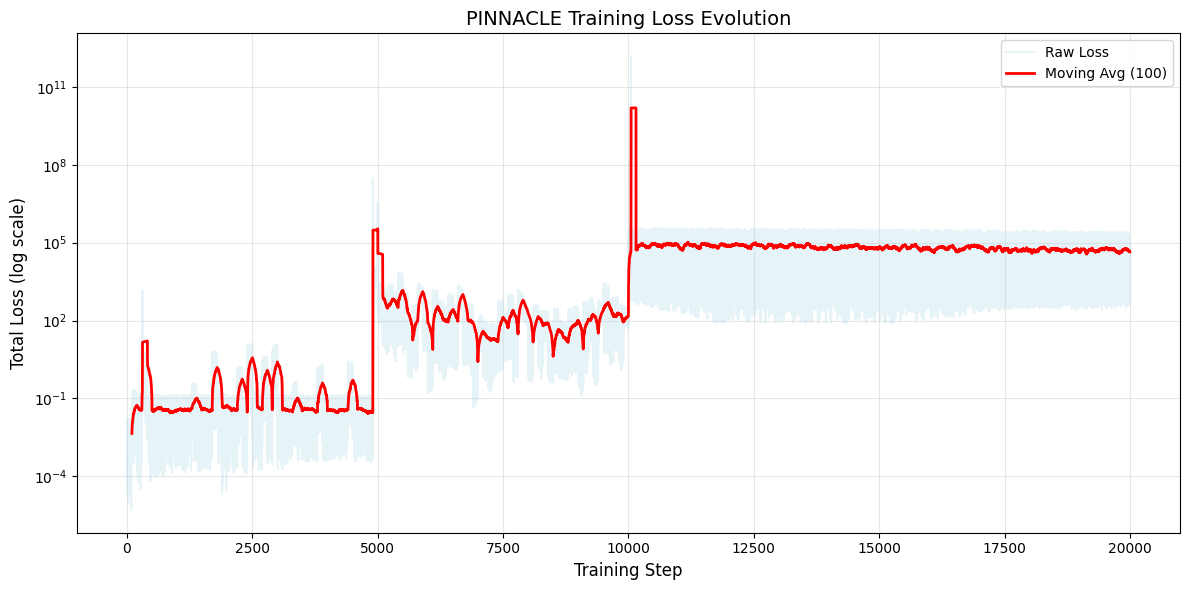

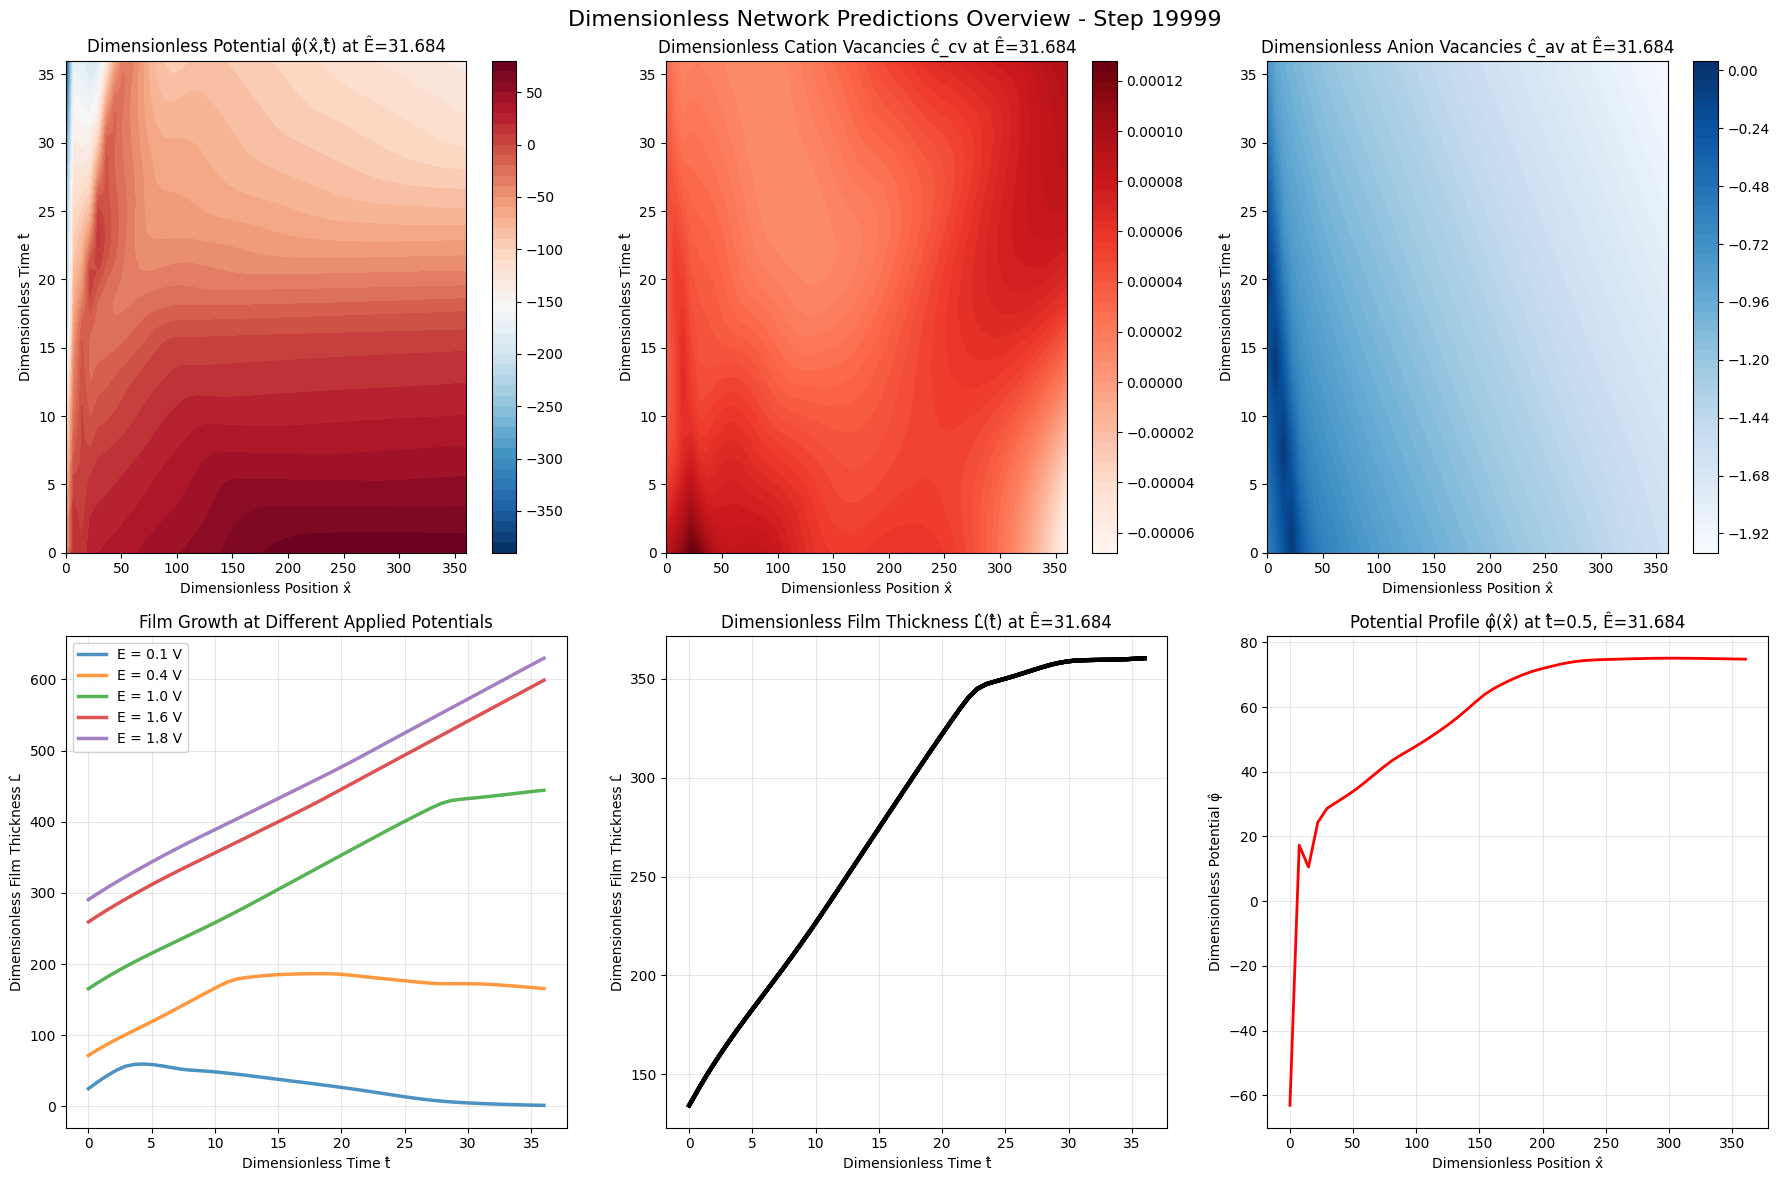

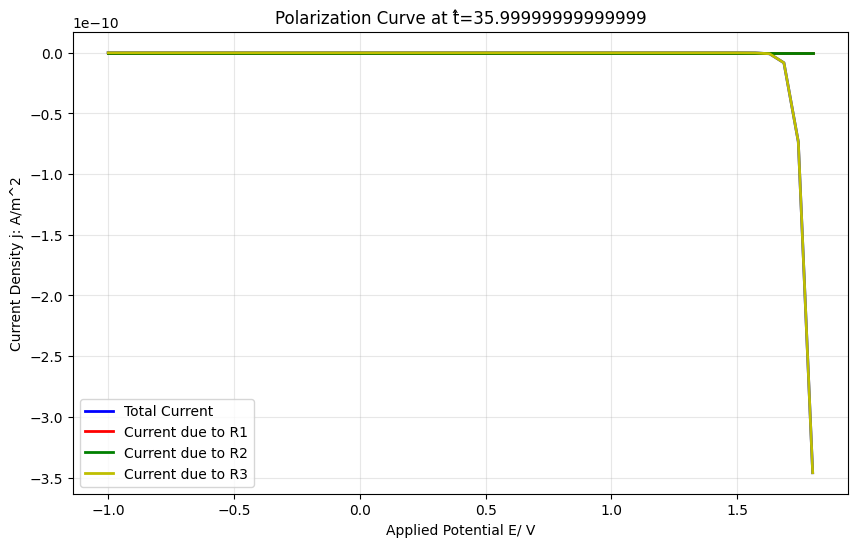

In [10]:
#Plotting

plt.figure(figsize=(12, 6))
window=100
# Raw loss
plt.plot(loss_history['total'], alpha=0.3, color='lightblue', label='Raw Loss')

# Moving average for smoother trend
if len(loss_history['total']) > window:
    moving_avg = np.convolve(loss_history['total'], np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(loss_history['total'])), moving_avg, 
        color='red', linewidth=2, label=f'Moving Avg ({window})')

plt.yscale('log')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Total Loss (log scale)', fontsize=12)
plt.title('PINNACLE Training Loss Evolution', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()


with torch.no_grad():
    # Define input ranges (all dimensionless)
    n_spatial = 50
    n_temporal = 50

    # Fix a representative dimensionless potential for visualization
    E_hat_fixed = torch.tensor([[0.8 / phic]], device=device)  # Normalized E

    # Dimensionless time range (0 to 1)
    t_hat_range = torch.linspace(0, time_scale / tc , n_temporal, device=device)

    # Get final dimensionless film thickness to set spatial range
    t_hat_final = torch.tensor([[time_scale / tc ]], device=device)
    L_hat_final = L_net(torch.cat([t_hat_final, E_hat_fixed], dim=1)).item()
    x_hat_range = torch.linspace(0, L_hat_final, n_spatial, device=device)

    print(f"  📐 Dimensionless time range: [0, 1.0]")
    print(f"  📐 Dimensionless spatial range: [0, {L_hat_final:.2f}]")
    print(f"  📐 Fixed dimensionless potential: {E_hat_fixed.item():.3f}")

    # Create 2D grid for contour plots
    T_hat_mesh, X_hat_mesh = torch.meshgrid(t_hat_range, x_hat_range, indexing='ij')
    E_hat_mesh = torch.full_like(T_hat_mesh, E_hat_fixed.item())

    # Stack inputs for 3D networks
    inputs_3d = torch.stack([
    X_hat_mesh.flatten(),
    T_hat_mesh.flatten(),
    E_hat_mesh.flatten()
    ], dim=1)

    # Get network predictions
    phi_hat_2d = u_net(inputs_3d).reshape(n_temporal, n_spatial)
    c_cv_hat_2d = cv_net(inputs_3d).reshape(n_temporal, n_spatial)
    c_av_hat_2d = av_net(inputs_3d).reshape(n_temporal, n_spatial)

    # Film thickness evolution (dimensionless)
    t_hat_1d = t_hat_range.unsqueeze(1)
    E_hat_1d = torch.full_like(t_hat_1d, E_hat_fixed.item())
    L_inputs_1d = torch.cat([t_hat_1d, E_hat_1d], dim=1)
    L_hat_1d = L_net(L_inputs_1d).squeeze()

    # Convert to numpy for plotting
    t_hat_np = t_hat_range.cpu().numpy()
    x_hat_np = x_hat_range.cpu().numpy()
    T_hat_np, X_hat_np = np.meshgrid(t_hat_np, x_hat_np, indexing='ij')

    phi_hat_np = phi_hat_2d.cpu().numpy()
    c_cv_hat_np = c_cv_hat_2d.cpu().numpy()
    c_av_hat_np = c_av_hat_2d.cpu().numpy()
    L_hat_np = L_hat_1d.cpu().numpy()

    # Create plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Dimensionless potential field
    im1 = axes[0, 0].contourf(X_hat_np, T_hat_np, phi_hat_np, levels=50, cmap='RdBu_r')
    axes[0, 0].set_xlabel('Dimensionless Position x̂')
    axes[0, 0].set_ylabel('Dimensionless Time t̂')
    axes[0, 0].set_title(f'Dimensionless Potential φ̂(x̂,t̂) at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im1, ax=axes[0, 0])

    # 2. Dimensionless cation vacancies
    im2 = axes[0, 1].contourf(X_hat_np, T_hat_np, c_cv_hat_np, levels=50, cmap='Reds')
    axes[0, 1].set_xlabel('Dimensionless Position x̂')
    axes[0, 1].set_ylabel('Dimensionless Time t̂')
    axes[0, 1].set_title(f'Dimensionless Cation Vacancies ĉ_cv at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im2, ax=axes[0, 1])

    # 3. Dimensionless anion vacancies
    im3 = axes[0, 2].contourf(X_hat_np, T_hat_np, c_av_hat_np, levels=50, cmap='Blues')
    axes[0, 2].set_xlabel('Dimensionless Position x̂')
    axes[0, 2].set_ylabel('Dimensionless Time t̂')
    axes[0, 2].set_title(f'Dimensionless Anion Vacancies ĉ_av at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im3, ax=axes[0, 2])


    # Select 5 representative potentials across the range
    E_values_dimensional = [0.1,0.4, 1.0, 1.6,1.8]  # Representative voltages
    E_hat_values = [E_val / phic for E_val in E_values_dimensional]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', "#8b61b3"]  # Distinct colors
    
    # Compute film growth for each potential
    L_hat_multi = []
    for E_hat_val in E_hat_values:
        E_hat_tensor = torch.full_like(t_hat_1d, E_hat_val)
        L_inputs_multi = torch.cat([t_hat_1d, E_hat_tensor], dim=1)
        L_hat_curve = L_net(L_inputs_multi).squeeze()
        L_hat_multi.append(L_hat_curve.cpu().numpy())
        
    # 4. Film Thickness Evoloution at non-steady state potentials
    for i, (L_curve, E_val, color) in enumerate(zip(L_hat_multi, E_values_dimensional, colors)):
        axes[1, 0].plot(t_hat_np, L_curve, color=color, linewidth=2.5, 
                        label=f'E = {E_val:.1f} V', alpha=0.8)
        axes[1, 0].set_xlabel('Dimensionless Time t̂')
        axes[1, 0].set_ylabel('Dimensionless Film Thickness L̂')
        axes[1, 0].set_title('Film Growth at Different Applied Potentials')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend(fontsize=10, framealpha=0.9)

        # 5. Dimensionless film thickness
        axes[1, 1].plot(t_hat_np, L_hat_np, 'k-', linewidth=3)
        axes[1, 1].set_xlabel('Dimensionless Time t̂')
        axes[1, 1].set_ylabel('Dimensionless Film Thickness L̂')
        axes[1, 1].set_title(f'Dimensionless Film Thickness L̂(t̂) at Ê={E_hat_fixed.item():.3f}')
        axes[1, 1].grid(True, alpha=0.3)

    # 5. Dimensionless film thickness
    axes[1, 1].plot(t_hat_np, L_hat_np, 'k-', linewidth=3)
    axes[1, 1].set_xlabel('Dimensionless Time t̂')
    axes[1, 1].set_ylabel('Dimensionless Film Thickness L̂')
    axes[1, 1].set_title(f'Dimensionless Film Thickness L̂(t̂) at Ê={E_hat_fixed.item():.3f}')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Potential profile vs spatial position at fixed time
    x_hat_sweep = torch.linspace(0, L_hat_final, 50, device=device)
    t_hat_mid = torch.full((50, 1), 0.5, device=device)  # Middle time
    E_hat_mid = torch.full((50, 1), E_hat_fixed.item(), device=device)

    x_sweep_inputs = torch.cat([x_hat_sweep.unsqueeze(1), t_hat_mid, E_hat_mid], dim=1)
    phi_vs_x = u_net(x_sweep_inputs).cpu().numpy()

    axes[1, 2].plot(x_hat_sweep.cpu().numpy(), phi_vs_x, 'r-', linewidth=2)
    axes[1, 2].set_xlabel('Dimensionless Position x̂')
    axes[1, 2].set_ylabel('Dimensionless Potential φ̂')
    axes[1, 2].set_title(f'Potential Profile φ̂(x̂) at t̂=0.5, Ê={E_hat_fixed.item():.3f}')
    axes[1, 2].grid(True, alpha=0.3)

    plt.suptitle(f'Dimensionless Network Predictions Overview - Step {step}', fontsize=16)
    plt.tight_layout()

    # Define potential range
    E_hat_min = E_min/phic 
    E_hat_max = E_max/phic
    n_points = 50
    t_hat_eval = time_scale / tc 
    with torch.no_grad():
        E_hat_values = torch.linspace(E_hat_min, E_hat_max, n_points, device=device)
        j={'total':[],'j1':[],'j2':[],'j3':[],'jtp':[]}

        for E_hat_val in E_hat_values:
            # Use dimensionless quantities throughout
            t_hat_tensor = torch.tensor([[t_hat_eval]], device=device)
            E_hat_tensor = torch.tensor([[E_hat_val.item()]], device=device)

            # Get dimensionless film thickness
            L_hat_val = L_net(torch.cat([t_hat_tensor, E_hat_tensor], dim=1))

            # Evaluate at interfaces
            x_hat_fs = L_hat_val  # f/s interface
            x_hat_mf = torch.zeros_like(L_hat_val)  # m/f interface

            inputs_fs = torch.cat([x_hat_fs, t_hat_tensor, E_hat_tensor], dim=1)
            inputs_mf = torch.cat([x_hat_mf, t_hat_tensor, E_hat_tensor], dim=1)

            # Get dimensionless concentrations and rate constants
            k1, k2, k3, k4, k5 = compute_rate_constants(t_hat_tensor, E_hat_tensor,
                                                                          single=True)

            
            cv_hat_mf = cv_net(inputs_mf)  # Dimensionless CV concentration
            av_hat_fs = av_net(inputs_fs)

            #Compute Currents
            j1 = (8.0/3.0)*F*k1*cv_hat_mf*cc
            j2 = (8.0/3.0)*F*k2
            j3 = (1.0/3.0)*F*k3*av_hat_fs*cc
            j_total = j1 +j2 + j3 
            j["total"].append(j_total.item())
            j["j1"].append(j1.item())
            j["j2"].append(j2.item())
            j["j3"].append(j3.item())

        # Convert to numpy for plotting
        E_np = E_hat_values.cpu().numpy()*phic
        j_np = np.array(j["total"])
        j_1_np = np.array(j['j1'])
        j_2_np = np.array(j['j2'])
        j_3_np = np.array(j['j3'])


        # Create polarization curve plot
        plt.figure(figsize=(10, 6))
        plt.plot(E_np, j_np, 'b-', linewidth=2, label='Total Current')
        plt.plot(E_np, j_1_np, 'r-', linewidth=2, label='Current due to R1')
        plt.plot(E_np, j_2_np, 'g-', linewidth=2, label='Current due to R2')
        plt.plot(E_np, j_3_np, 'y-', linewidth=2, label='Current due to R3')
        plt.xlabel('Applied Potential E/ V')
        plt.ylabel('Current Density j: A/m^2')
        plt.title(f'Polarization Curve at t̂={t_hat_eval}')
        plt.legend()
        #TODO: Make the X-Axis plots finer. 
        plt.grid(True, alpha=0.3)
        plt.legend()

plt.show()